# Basic Machine Learning algorithm testing

## Imports
The following libraries are imported for data manipulation and visualization:
- `pandas` for working with dataframes
- `numpy` for numerical operations
- `matplotlib` for data visualization
- `os` and `time` for system operations
- `sklearn` for algorithms and models
- `pytorch` for advanced models

In [3]:
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import numpy as np
import time


# Data Prep-up
Firstly we need to import our numeric and categorical data (we use previous part to split the data with basic sklearn algorithm)

In [4]:
data = pd.read_csv("Spotify_Youtube.csv", encoding="utf-8")

test_proportion = 0.25 # declares what number of data will be dedicated to testing (higher = faster)

# clean-up of the data - removing urls, descriptions, itp.
columns_to_exclude = [col for col in data.columns if col == 'Unnamed: 0' or col.lower() == 'uri' or 'url_' in col.lower() or 'description' in col.lower() or col == '']
data = data[data.columns.difference(columns_to_exclude)]

if os.path.exists("estimates/estimated_data.csv"):
    os.remove("estimates/estimated_data.csv")

data.head()

,Acousticness,Album,Album_type,Artist,Channel,Comments,Danceability,Duration_ms,Energy,Instrumentalness,...,Liveness,Loudness,Speechiness,Stream,Tempo,Title,Track,Valence,Views,official_video
0,0.008360,Demon Days,album,Gorillaz,Gorillaz,169907.0,0.818,222640.0,0.705,0.002330,...,0.6130,-6.679,0.1770,1.040235e+09,138.559,Gorillaz - Feel Good Inc. (Official Video),Feel Good Inc.,0.772,693555221.0,True
1,0.086900,Plastic Beach,album,Gorillaz,Gorillaz,31003.0,0.676,200173.0,0.703,0.000687,...,0.0463,-5.815,0.0302,3.100837e+08,92.761,Gorillaz - Rhinestone Eyes [Storyboard Film] (...,Rhinestone Eyes,0.852,72011645.0,True
2,0.042500,New Gold (feat. Tame Impala and Bootie Brown),single,Gorillaz,Gorillaz,7399.0,0.695,215150.0,0.923,0.046900,...,0.1160,-3.930,0.0522,6.306347e+07,108.014,Gorillaz - New Gold ft. Tame Impala & Bootie B...,New Gold (feat. Tame Impala and Bootie Brown),0.551,8435055.0,True
3,0.000015,Plastic Beach,album,Gorillaz,Gorillaz,55229.0,0.689,233867.0,0.739,0.509000,...,0.0640,-5.810,0.0260,4.346636e+08,120.423,Gorillaz - On Melancholy Hill (Official Video),On Melancholy Hill,0.578,211754952.0,True
4,0.025300,Gorillaz,album,Gorillaz,Gorillaz,155930.0,0.663,340920.0,0.694,0.000000,...,0.0698,-8.627,0.1710,6.172597e+08,167.953,Gorillaz - Clint Eastwood (Official Video),Clint Eastwood,0.525,618480958.0,True


Now we need to state the Goal of our training model - for us it will be Streams on Spotify - as we would like to predict which song will be popular.

In [5]:
data = data.dropna(subset=['Stream']) # any NAs will be not valid

# getting categorical and numeric stats
numeric_stats = data.select_dtypes(include=['number'])
categorical_stats = data.select_dtypes(include=['object'])

numeric_stats.head()

,Acousticness,Comments,Danceability,Duration_ms,Energy,Instrumentalness,Key,Likes,Liveness,Loudness,Speechiness,Stream,Tempo,Valence,Views
0,0.008360,169907.0,0.818,222640.0,0.705,0.002330,6.0,6220896.0,0.6130,-6.679,0.1770,1.040235e+09,138.559,0.772,693555221.0
1,0.086900,31003.0,0.676,200173.0,0.703,0.000687,8.0,1079128.0,0.0463,-5.815,0.0302,3.100837e+08,92.761,0.852,72011645.0
2,0.042500,7399.0,0.695,215150.0,0.923,0.046900,1.0,282142.0,0.1160,-3.930,0.0522,6.306347e+07,108.014,0.551,8435055.0
3,0.000015,55229.0,0.689,233867.0,0.739,0.509000,2.0,1788577.0,0.0640,-5.810,0.0260,4.346636e+08,120.423,0.578,211754952.0
4,0.025300,155930.0,0.663,340920.0,0.694,0.000000,10.0,6197318.0,0.0698,-8.627,0.1710,6.172597e+08,167.953,0.525,618480958.0


It is better to exclude such stats as Youtube views, likes and comments as they reveal too much info.

In [6]:
columns_to_exclude = ["Views", "Comments", "Likes", "Stream"] # of course, we need to exclude our Goal stat as well

numeric_stats_reduced = numeric_stats.drop(columns = [col for col in columns_to_exclude if col in numeric_stats])
numeric_stats_reduced.head()

,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Key,Liveness,Loudness,Speechiness,Tempo,Valence
0,0.008360,0.818,222640.0,0.705,0.002330,6.0,0.6130,-6.679,0.1770,138.559,0.772
1,0.086900,0.676,200173.0,0.703,0.000687,8.0,0.0463,-5.815,0.0302,92.761,0.852
2,0.042500,0.695,215150.0,0.923,0.046900,1.0,0.1160,-3.930,0.0522,108.014,0.551
3,0.000015,0.689,233867.0,0.739,0.509000,2.0,0.0640,-5.810,0.0260,120.423,0.578
4,0.025300,0.663,340920.0,0.694,0.000000,10.0,0.0698,-8.627,0.1710,167.953,0.525


Now it is time to create a pipeline - series of steps that will be used on data in order to prepare it for model-training. We use pipelines as they automatically remember the parameters of the data's transformations (ex. all previous artists in one-hot encoding as not to give 1 artist 2 different "ids").

In [7]:
X = pd.concat([numeric_stats_reduced, categorical_stats], axis=1) # we need to concat the data for the pipeline to use

Y = numeric_stats["Stream"] # our Goal

numeric_features = numeric_stats_reduced.columns.tolist() # returns list of strings
categorical_features = categorical_stats.columns.tolist() # we use that to give pipeline info which columns are numeric and which are categorical


Now for the pipeline itself.

In [8]:

# for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # if NA then fill with mean
    ('scaler', StandardScaler()) # then normalize
])

# for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # if NA then fill with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# for categorical data with PCA reduction
categorical_transformer_PCA = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # if NA then fill with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('pca', PCA(n_components=100)), # we use PCA algorithm to reduce size of the data - so memory usage as well
])

We also need to do a ColumnTransformer.

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# with PCA reduction
preprocessor_PCA = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_PCA, categorical_features),
    ]
)

And now we need to split our data for training usage and examination usage.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_proportion, random_state=40
)
X_train = X_train.reset_index(drop=True)
X_train.sort_index()
y_train = y_train.reset_index(drop=True)
y_train.sort_index()
X_test = X_test.reset_index(drop=True)
X_test.sort_index()
y_test = y_test.reset_index(drop=True)
y_test.sort_index()

0       140786187.0
1       107436637.0
2        89466323.0
3        41796649.0
4         1670944.0
           ...     
5031       162740.0
5032     51272250.0
5033     11471926.0
5034      3574337.0
5035     42381225.0
Name: Stream, Length: 5036, dtype: float64

Let's also add simple function to save our results in csv.

In [11]:

def save_model_results(model_name, res_train, res_test, csv_path='estimated_data.csv', reset=False):
    """
    Saves result (name, MSE, R²) to CSV.

    Parameters:
    csv_path: str – CSV filepath
    model_name: str – ex. 'Linear Regression'
    res_train - tuple with (MSE,R²)
    """
    new_row = {
        'Model': model_name,
        'MSE_Train': res_train[0],
        'R2_Train': res_train[1],
        'MSE_Test': res_test[0],
        'R2_Test': res_test[1]
    }

    os.makedirs('estimates', exist_ok=True)
    full_path = os.path.join('estimates', csv_path)

    if os.path.exists(full_path) and not reset:
        df = pd.read_csv(full_path)
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    else:
        df = pd.DataFrame([new_row])

    df.to_csv(full_path, index=False)
    print(f"Saved to {full_path}")


And a function for testing.

In [12]:
def getResult(prediction, actual):
    mse = mean_squared_error(actual, prediction)
    r2 = r2_score(actual, prediction)
    return mse,r2

# 1. Basic Sklearn Models

### Data prep-up
All good so far. Let's build first basic models based on: Linear Regression, Random Forrest and SVR (Support Vector Regressor) as well as SGD (Stochastic Gradient Regressor).

In [13]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor), # our preprocessing
    ('model', LinearRegression())
])

pipeline_lr_pca = Pipeline(steps=[
    ('preprocessor', preprocessor_PCA), # for comparison
    ('model', LinearRegression())
])

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_svr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='rbf', C=10.0, epsilon=0.05)) # rbf for not-linear correlations
])

pipeline_sgd = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SGDRegressor(loss='squared_error', learning_rate='constant', eta0=0.01, random_state=42, max_iter=5000, tol=1e-4, shuffle=True)),
])

### Training

Now let's train it.

In [ ]:
pipelines=[
    ('Linear Regression' ,pipeline_lr.fit(X_train, y_train)), # train on training set
    ('Linear Regression with PCA', pipeline_lr_pca.fit(X_train, y_train)),
    ('Random Forest', pipeline_rf.fit(X_train, y_train)),
    ('Support Vector Regressor', pipeline_svr.fit(X_train, y_train)),
    ('Stochastic Gradient Descent',pipeline_sgd.fit(X_train, y_train))
    ]

### Estimation

And now the estimation.

In [219]:
predictions = {}
for name, model in pipelines:
    predictions[name] = model.predict(X_train), model.predict(X_test)

### Results

Let's see how they did.

In [220]:

for name, _ in pipelines:
    train_res = getResult(predictions[name][0], y_train)
    test_res = getResult(predictions[name][1], y_test)
    print(f"{name:<25} | MSE: {test_res[0]:,.0f} | R²: {test_res[1]:.4f}")
    save_model_results(name, train_res, test_res)


Linear Regression         | MSE: 30,419,721,239,474,360 | R²: 0.4882
Saved to estimates\estimated_data.csv
Linear Regression with PCA | MSE: 53,111,796,668,364,816 | R²: 0.1064
Saved to estimates\estimated_data.csv
Random Forest             | MSE: 37,178,621,406,047,912 | R²: 0.3745
Saved to estimates\estimated_data.csv
Support Vector Regressor  | MSE: 67,300,784,072,798,800 | R²: -0.1323
Saved to estimates\estimated_data.csv
Stochastic Gradient Descent | MSE: 312,499,149,465,945,088 | R²: -4.2577
Saved to estimates\estimated_data.csv


### Takeaways:
1. Linear Regression - surprisingly the simplest algorithm got the best score in estimation.
2. Random Forest - still pretty good accuracy.
3. SVR - as we can see this way was even worse then guessing a value based on a mean (r2<0). It is not really a surprise as our data contains a lot of outliers that SVR doesn't really take into account.
4. SGD - very close to normal (closed) Linear Regression.

Let's visualize some of the estimations.

In [221]:
def draw_chart(estimation, name: str, seed=None):
    # random 10 titles
    sample = X_test.sample(n=10, random_state=seed)

    titles = sample['Title'].fillna('No title').astype(str)

    titles_short = titles.apply(lambda x: (x[:30] + '...') if len(x) > 30 else x)

    sample_pos = sample.index.to_numpy()

    true_values = y_test.iloc[sample_pos]
    pred_values = estimation[sample_pos]

    plt.figure(figsize=(12, 6))
    plt.plot(titles_short, true_values, marker='o', label='Actual Streams')
    plt.plot(titles_short, pred_values, marker='o', label='Estimated Streams')
    plt.xlabel('Title')
    plt.ylabel('Streams')
    plt.title(f'{name} - Estimated vs Actual Streams')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()




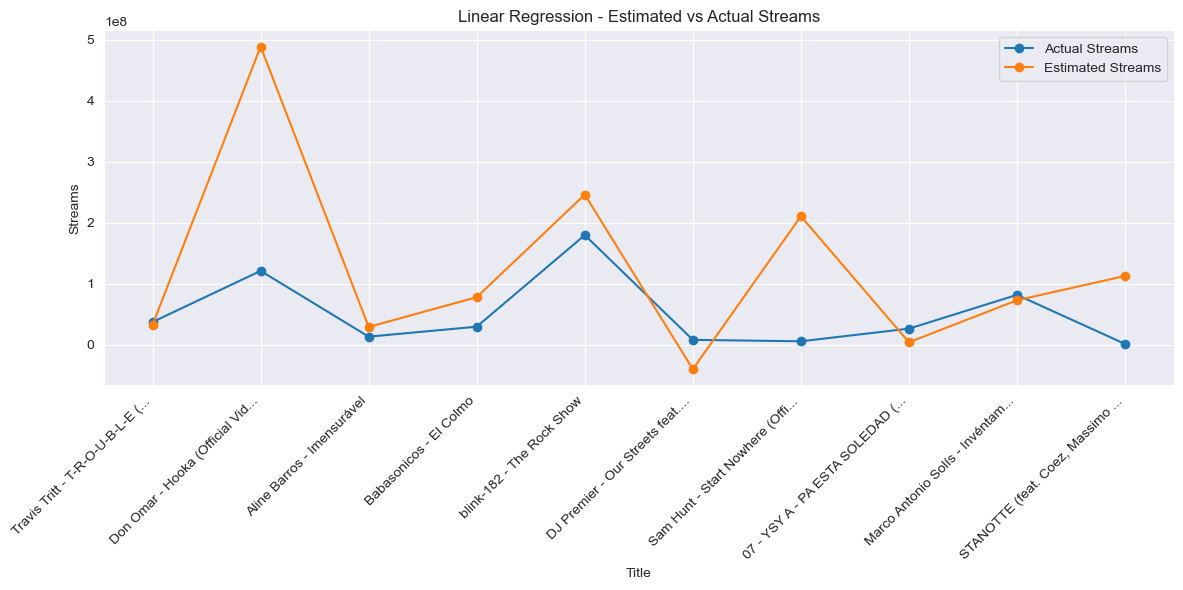

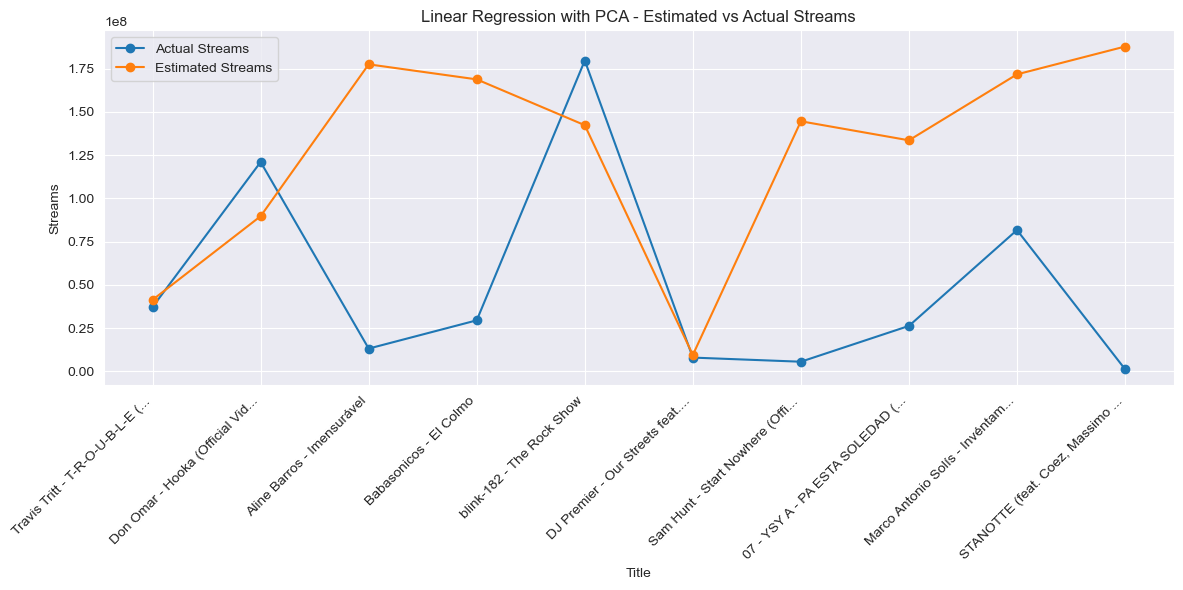

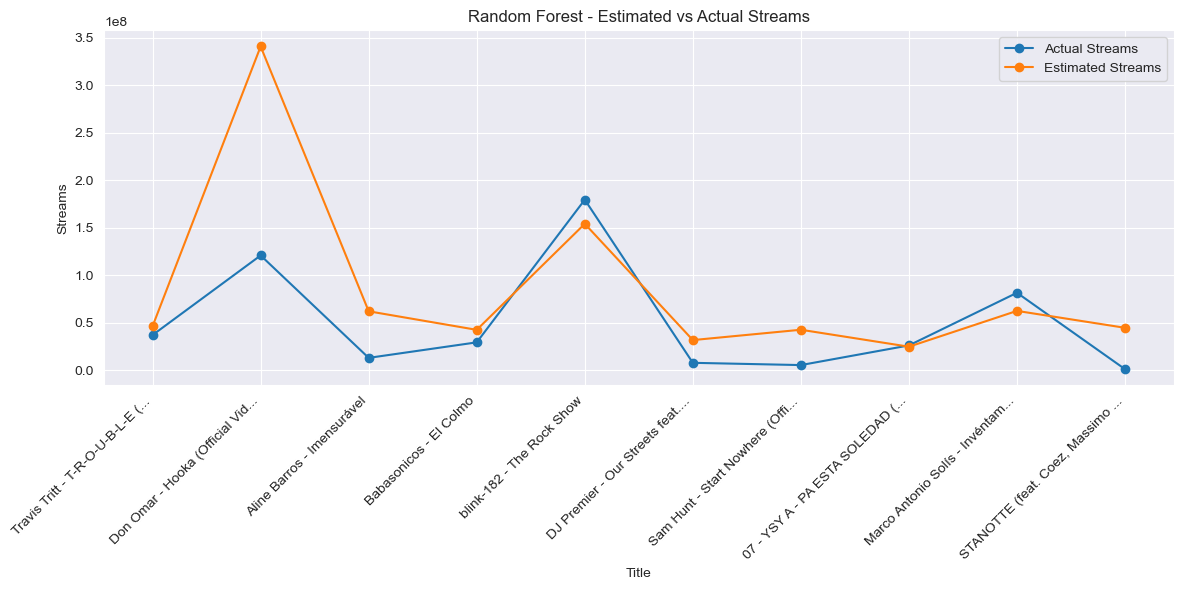

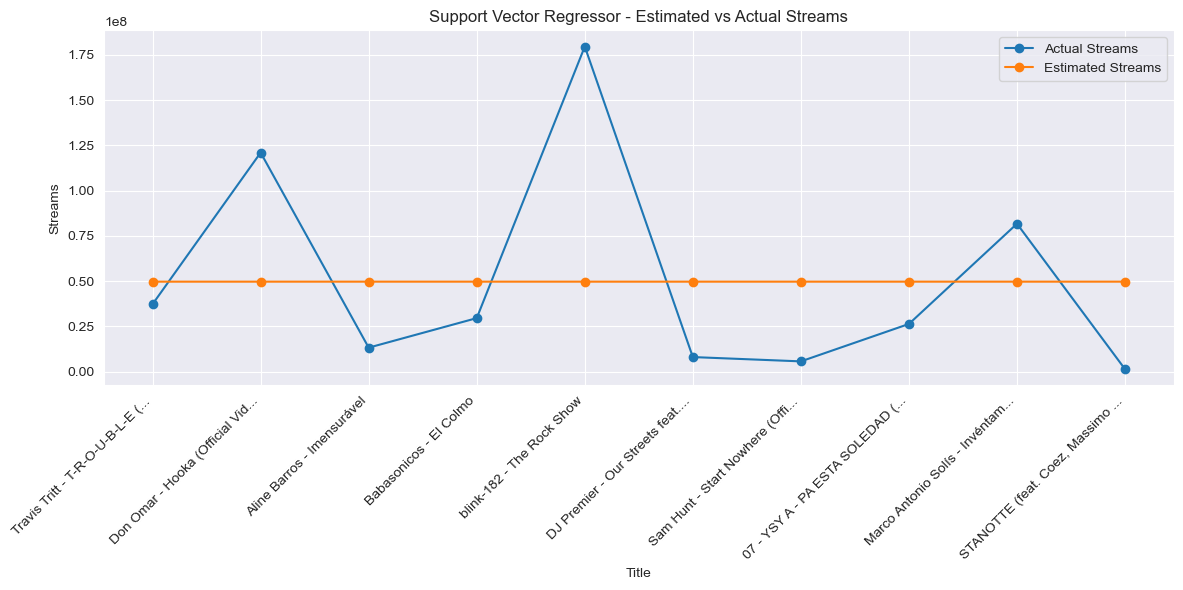

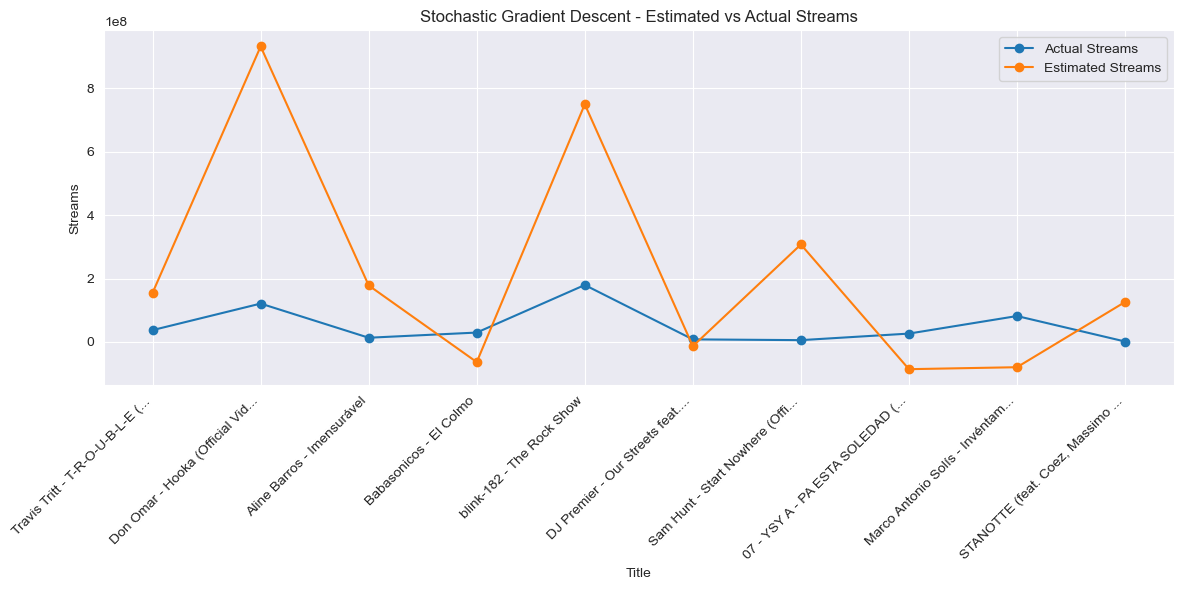

In [222]:
for name, _ in pipelines:
    draw_chart(predictions[name][1], name, seed=10)

# 2 - Own Implementation: Closed Linear Regression / Gradient Descent

### Data Prep-up
Now let's try to implement basic Linear Regression using only numpy. First we need to add bias - this will help us determine the offset from 0,0 point (normal b in linear function).

In [223]:
X_train_proc = preprocessor.fit_transform(X_train) # transform to one-hot encode and normalize
X_proc_pca = preprocessor_PCA.fit_transform(X_train) # same but with PCA added
X_train_proc = X_train_proc.toarray()
X_train_b = np.hstack([np.ones((X_train_proc.shape[0], 1)), X_train_proc])
X_train_b_pca = np.hstack([np.ones((X_proc_pca.shape[0], 1)), X_proc_pca]) # this will make the computing automatic, as w0 - first wage will be equal to offset from the OX (b).

X_test_proc = preprocessor.transform(X_test)
X_test_proc_pca = preprocessor_PCA.transform(X_test)
X_test_proc = X_test_proc.toarray()
X_test_b = np.hstack([np.ones((X_test_proc.shape[0], 1)), X_test_proc])
X_test_b_pca = np.hstack([np.ones((X_test_proc_pca.shape[0], 1)), X_test_proc_pca]) # we must add bias to test data as well

## Closed Linear Regression

### Training

Now some math's - There are 2 functions we need to consider during Linear Regression:
1. Cost function - this will help model understand whether it's making progress in the right direction.
2. Linear function itself - a basic linear function with offset (b).

For us:
Linear function = b (bias) + w1 (wage) * x1 (parameter) + w2 * x2 + ....

Cost function = C(w) = || X (parameter's matrix) ⋅ w (wage vector) - y (actual value) ||^2 - so basically distance between estimated and real value

Now if we solve Cost function's derivative for w, we get:

w = (XT (transposed) ⋅ X) ^ (-1) ⋅ XT ⋅ y

So now to the code.

In [224]:
XtX = X_train_b_pca.T @ X_train_b_pca # Transposed * matrix (correlation matrix)

XtX_inv = np.linalg.pinv(XtX) # Matrix inversion (using SVM to get results that are close to actual, while still using One-hot)

XtY = X_train_b_pca.T @ y_train # Second part of the equation

w_closed = XtX_inv @ XtY # last part - result (optimal wages)

### Results

After following the equation we now have most optimal wages for our model - so we basically did the "fitting" part manually. Now let's see results.

In [225]:
y_pred_closed = X_test_b_pca @ w_closed
y_pred_train = X_train_b_pca @ w_closed

test_res = getResult(y_pred_closed, y_test)
train_res = getResult(y_pred_train, y_train)

print(f"Own Linear Regression | MSE: {test_res[0]:,.0f} | R²: {test_res[1]:.4f}")
save_model_results( "Own closed Linear Regression", train_res, test_res)

Own Linear Regression | MSE: 53,111,796,668,364,808 | R²: 0.1064
Saved to estimates\estimated_data.csv


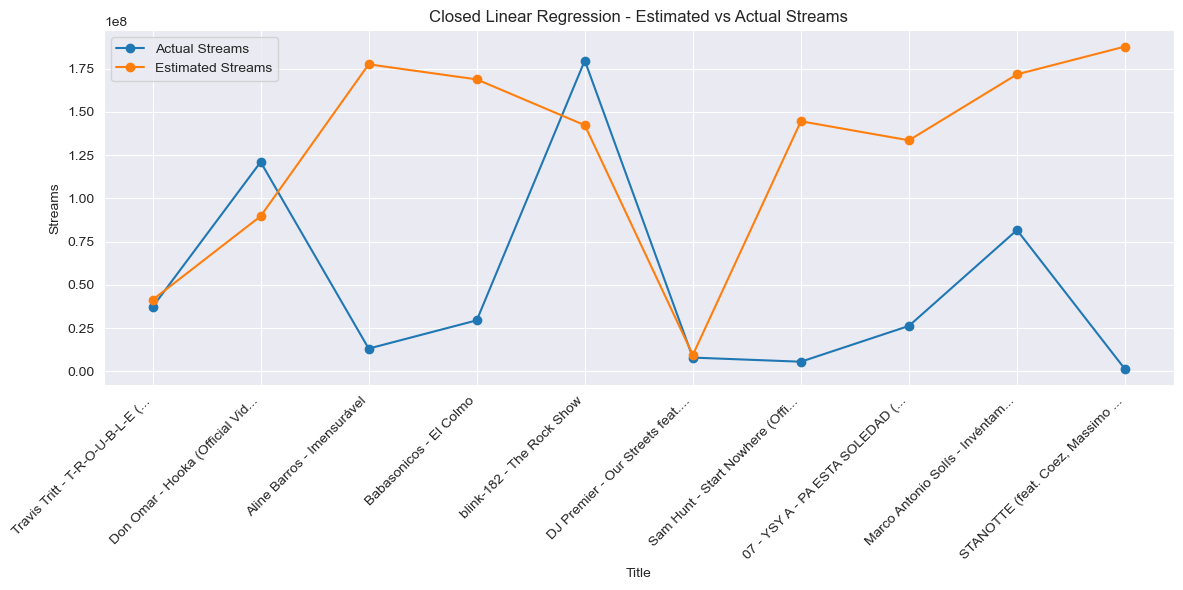

In [226]:
draw_chart(y_pred_closed, "Closed Linear Regression", seed=10)

As we can see the results are pretty close to the previous (sklearn) Linear Regression - most likely because of different SVM implementations (or QR utilization).

So now we can analyze the drawbacks of this closed method :
1. It takes a very long time, as it has O(n^3) time complexity.
2. Can take a lot of memory if used on very large data sets.
3. Doesn't work for more complex (not-linear) models.

### Gradient Descent

With gradient approach - basics remain the same (aka. main functions - Linear Regression and bias). The change comes with Cost functions that is now a bit different:

Cost function (MSE) = 1/2n * ||X⋅w - y||^2 -> so we basically make a mean out of our previous function

So derivative (gradient) from this function is:

∇C(w) = 1/n * XT ⋅ (X⋅w − y)

So the whole concept of this approach is to move in the direction that ensures error reduction (contrary to gradient).

In [227]:
def gradient_descent(X, y, w_init, learning_rate=0.01, *, iterations=1000, epsilon=None, batch_size=32):
    n = len(y)
    w = w_init.copy()
    cost_history = []

    for i in range(iterations):
        # random choices for batch
        batch_indices = np.random.choice(n, size=batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]

        predictions = X_batch @ w

        gradient = (1 / batch_size) * (X_batch.T @ (predictions - y_batch))

        w = w - learning_rate * gradient # wages actualisation
        full_predictions = X @ w
        cost = mean_squared_error(y, full_predictions)
        cost_history.append(cost)

        if epsilon is not None and i > 0:
            if abs(cost_history[-2] - cost_history[-1]) < epsilon:
                print(f"Stopped early at iteration {i} (change < epsilon={epsilon})")
                break

    return w, cost_history

### Training

So let's take this function for a spin.

In [228]:
w_grad, cost_history = gradient_descent(X_train_b, y_train, np.random.randn(X_train_b.shape[1]), iterations=5000) # initialize w with random values

Ok, now the "fitting" part is done. We actually can see how it searched for the minimum (bear in mind this is training test).

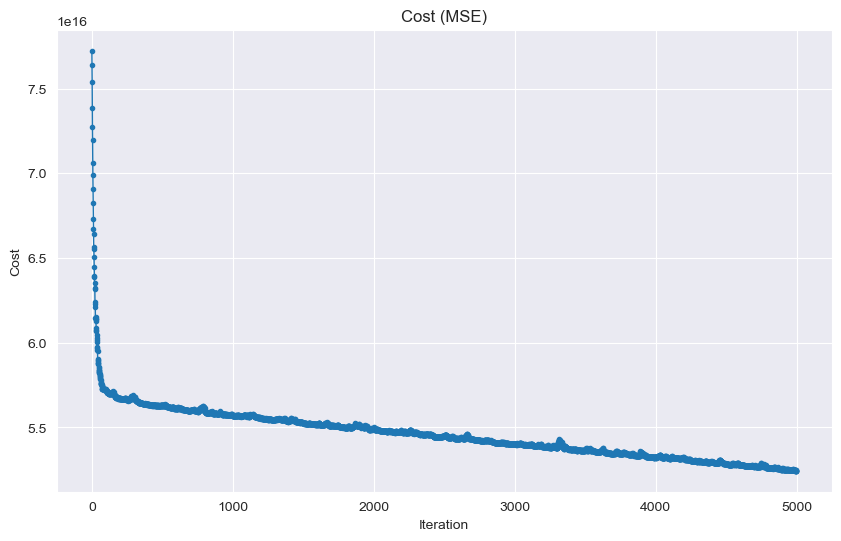

In [229]:
plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o', markersize=3, linewidth=1)
plt.title("Cost (MSE)")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

### Results

And now for the results.

In [230]:
y_pred_grad = X_test_b @ w_grad
y_pred_train = X_train_b @ w_grad

train_res = getResult(y_pred_train, y_train)
test_res = getResult(y_pred_grad, y_test)

print(f"Own Gradient Descent | MSE: {test_res[0]:,.0f} | R²: {test_res[1]:.4f}")
save_model_results("Own Gradient Descent", train_res, test_res)

Own Gradient Descent | MSE: 54,144,188,566,764,904 | R²: 0.0890
Saved to estimates\estimated_data.csv


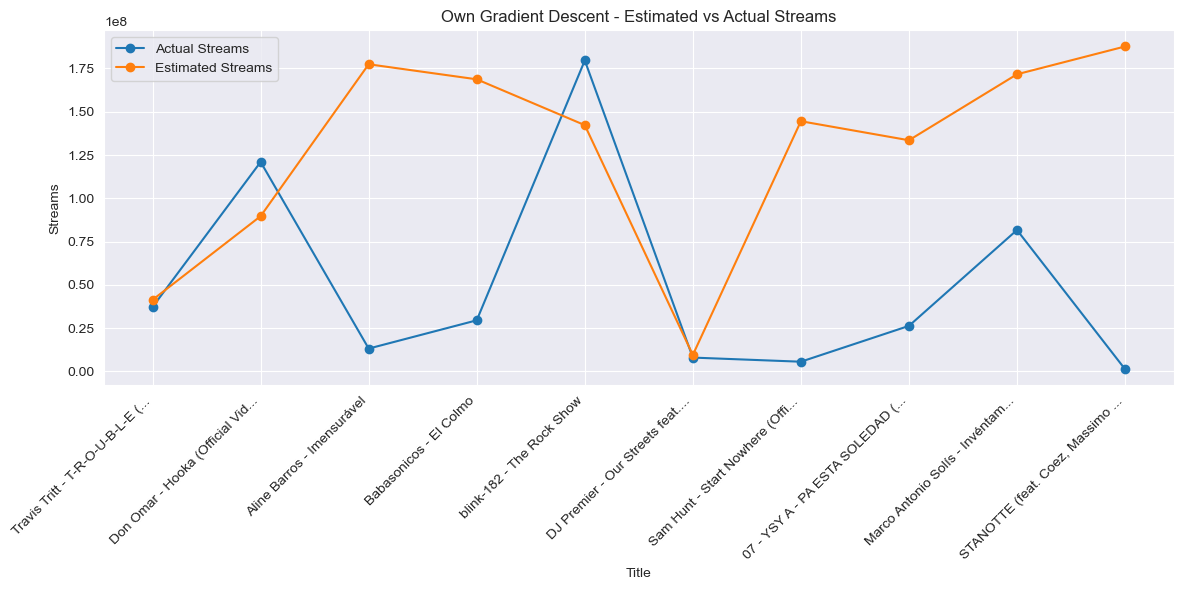

In [231]:
draw_chart(y_pred_closed, "Own Gradient Descent", seed=10)


In [232]:
def plot_metric_from_csv(csv_path, column_name):
    """
    Makes plot from csv file of column name.

    Parameters:
    - csv_path: str – path to csv file
    - column_name: str – ex. 'MSE_Train', 'MSE_Test', 'R2_Train', 'R2_Test'
    """
    df = pd.read_csv(csv_path)

    if column_name not in df.columns:
        raise ValueError(f"Column not found '{column_name}' in CSV.")

    models = df['Model']
    values = df[column_name]

    plt.figure(figsize=(12, 6))

    x_pos = range(len(models))

    plt.scatter(x_pos, values, s=100, color='tab:blue')

    plt.title(f"{column_name} for Models")
    plt.xlabel("Model")
    plt.ylabel(column_name)
    plt.xticks(x_pos, models, rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

## Comparison

If we would like to compare results of our own implementation to the one from sklearn, here we can see that.

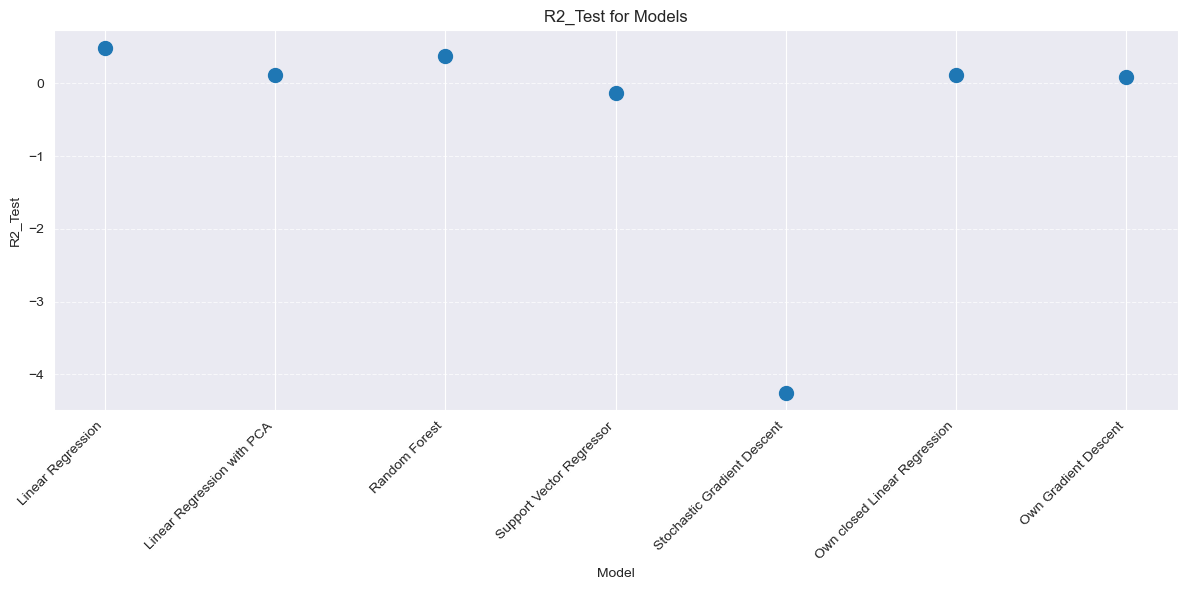

In [233]:
plot_metric_from_csv('estimates/estimated_data.csv','R2_Test')

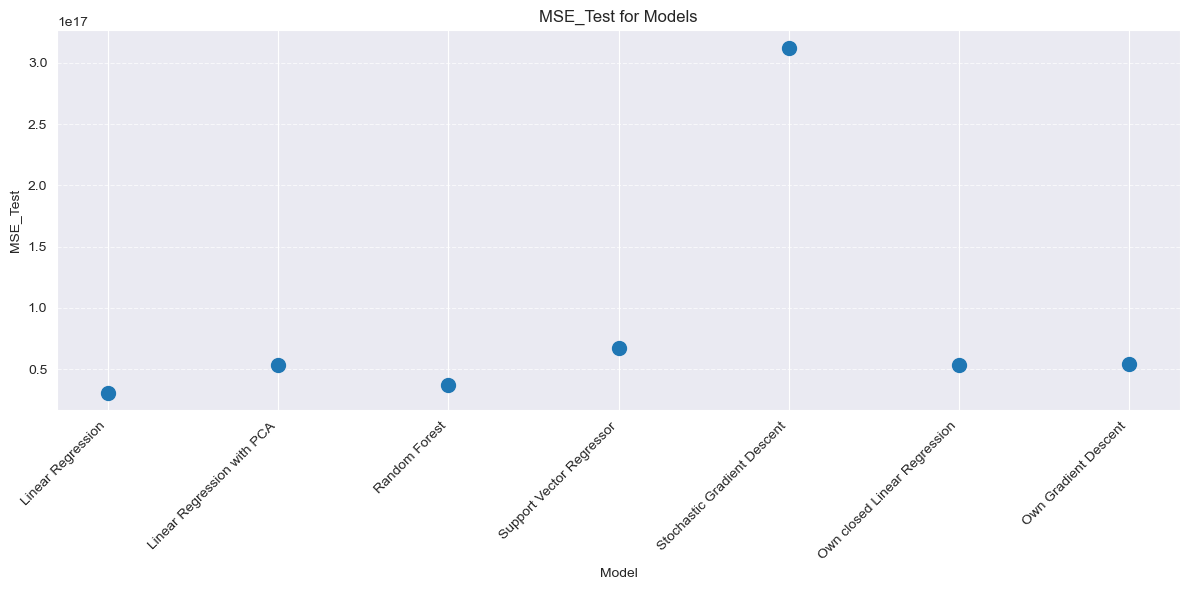

In [234]:
plot_metric_from_csv('estimates/estimated_data.csv','MSE_Test')

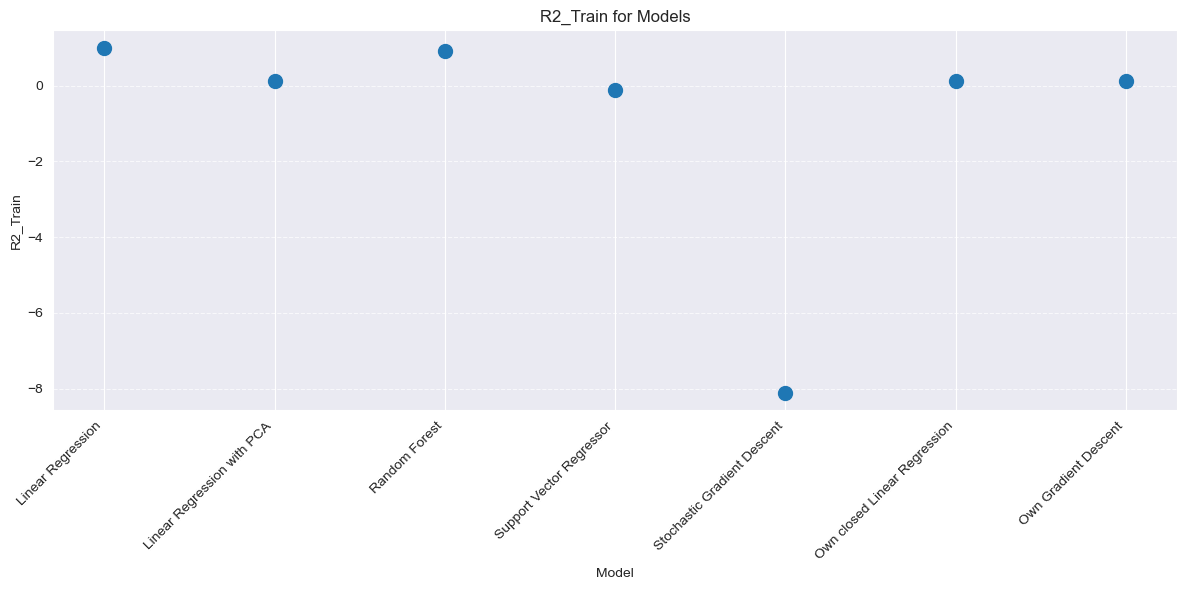

In [235]:
plot_metric_from_csv('estimates/estimated_data.csv','R2_Train')

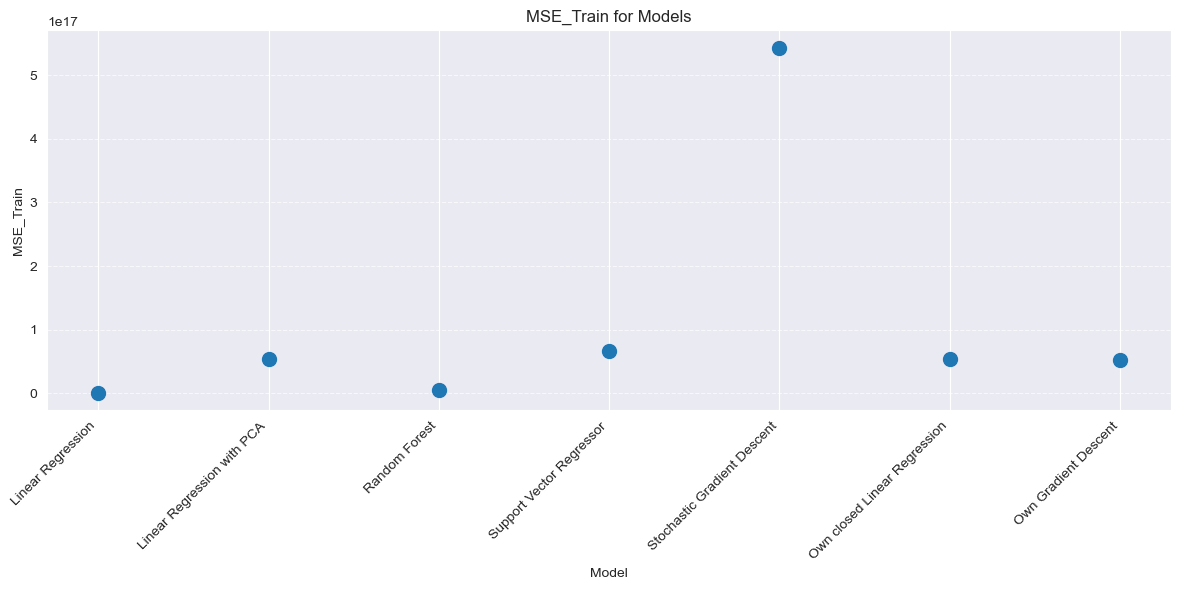

In [236]:
plot_metric_from_csv('estimates/estimated_data.csv','MSE_Train')

In [237]:
results = pd.read_csv('estimates/estimated_data.csv')
results.head(10)

,Model,MSE_Train,R2_Train,MSE_Test,R2_Test
0,Linear Regression,6.608596e+10,0.999999,3.041972e+16,0.488201
1,Linear Regression with PCA,5.311953e+16,0.109458,5.311180e+16,0.106416
2,Random Forest,5.516713e+15,0.907513,3.717862e+16,0.374485
3,Support Vector Regressor,6.695343e+16,-0.122466,6.730078e+16,-0.132308
4,Stochastic Gradient Descent,5.437334e+17,-8.115624,3.124991e+17,-4.257671
5,Own closed Linear Regression,5.311953e+16,0.109458,5.311180e+16,0.106416
6,Own Gradient Descent,5.245740e+16,0.120558,5.414419e+16,0.089046


### Takeaways:
1. Using PCA significantly worsens the results.
2. For our problem - best results come from regressions.
3. SVR just doesn't work for this dataset - too much variety.

# 3 - PyTorch implementation

### Data prep-up

Now, we will try to implement Linear Regression using PyTorch library

In [238]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

First - device selection.

In [239]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device used:", device)
print(torch.__version__)

Device used: cuda
2.5.1


Then conversion.

In [240]:
X_tensor = torch.tensor(X_train_proc, dtype=torch.float32) # we use processed data (after one-hot and normalized)
y_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32) # reshape, because we need it as a column

Now some we define data structures that will help us with batching and etc.

In [241]:
dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # shuffle lets us reuse data during training


The actual model looks like this.

In [242]:
class LinearRegressionModel(nn.Module): # extends nn.Module
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1) #  defines the linear part - with input features and only 1 output feature - Streams

    def forward(self, x): # defines how to compute inputted data
        return self.linear(x)


The good thing is that PyTorch automatically creates wage matrix and adds bias.

In [243]:
input_dim = X_train_proc.shape[1] # number of features
model = LinearRegressionModel(input_dim)

criterion = nn.MSELoss() # criteria - MSE
optimizer = optim.SGD(model.parameters(), lr=0.01) # Optimize using Stochastic Gradient Descent

Now it's time for the essence - training function.

In [244]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    """
    Trains PyTorch model with PyTorch DataLoader, criterion, and optimizer using device in number of epochs.
    :param model: PyTorch model
    :param train_loader: PyTorch DataLoader
    :param criterion: Criterion with loss function
    :param optimizer: Optimizer ex. torch.optim.SGD
    :param device: Cuda or Cpu
    :param epochs: How many epochs to train model with
    :return: Nothing
    """
    model.train() # sets the internal flag to train mode
    model.to(device)
    for epoch in range(epochs):
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader: # gets already made batches with shuffle true - same data might be reused
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) # moves to the same device as model

            optimizer.zero_grad() # resets the gradient - as we use completely different batch every time
            outputs = model(X_batch) # estimates
            loss = criterion(outputs, y_batch) # results from loss function
            loss.backward() # calculates gradients for every parameter
            optimizer.step() # actualizes wages

            epoch_loss += loss.item() * X_batch.size(0)

        avg_loss = epoch_loss / len(train_loader.dataset)
        print(f"{device} : Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


### Training

Now we can see how much time is needed to train our model.

In [245]:
# for CPU
start_time = time.time()
train_model(model, train_loader, criterion, optimizer, 'cpu', epochs=10)
elapsed_time_cpu = time.time() - start_time

# for GPU
start_time = time.time()
train_model(model, train_loader, criterion, optimizer, device, epochs=10)
elapsed_time = time.time() - start_time

print(f"Training time with GPU: {elapsed_time:.2f} s | CPU time: {elapsed_time_cpu:.2f} s")


cpu : Epoch [1/10], Loss: 56936540527854896.0000
cpu : Epoch [2/10], Loss: 55675237980739264.0000
cpu : Epoch [3/10], Loss: 54924426046336712.0000
cpu : Epoch [4/10], Loss: 54100243813257280.0000
cpu : Epoch [5/10], Loss: 53405418549025968.0000
cpu : Epoch [6/10], Loss: 52661969045301856.0000
cpu : Epoch [7/10], Loss: 51937334437512328.0000
cpu : Epoch [8/10], Loss: 51230399235136312.0000
cpu : Epoch [9/10], Loss: 50519477529327448.0000
cpu : Epoch [10/10], Loss: 49839261423059248.0000
cuda : Epoch [1/10], Loss: 49219887045032696.0000
cuda : Epoch [2/10], Loss: 48516607065603592.0000
cuda : Epoch [3/10], Loss: 47973856958790216.0000
cuda : Epoch [4/10], Loss: 47337836888967728.0000
cuda : Epoch [5/10], Loss: 46706203464346360.0000
cuda : Epoch [6/10], Loss: 46105386159114976.0000
cuda : Epoch [7/10], Loss: 45549351822516904.0000
cuda : Epoch [8/10], Loss: 45005133591905224.0000
cuda : Epoch [9/10], Loss: 44428101221894872.0000
cuda : Epoch [10/10], Loss: 43932428663906424.0000
Training

### Results

As we can see - it is trained in relatively short time (thanks to GPU usage). Results may now be calculated.

In [246]:
model.eval()

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_proc, dtype=torch.float32).to(device)
    X_train_tensor = torch.tensor(X_train_proc, dtype=torch.float32).to(device)
    predictions = model(X_test_tensor)
    test_predictions = predictions.cpu().numpy()
    predictions = model(X_train_tensor)
    train_predictions = predictions.cpu().numpy()

test_res = getResult(test_predictions, y_test)
train_res = getResult(train_predictions, y_train)

save_model_results("PyTorch Linear Regression", train_res, test_res)
print(f"PyTorch Linear Regression | MSE: {test_res[0]:,.0f} | R²: {test_res[1]:.4f}")

Saved to estimates\estimated_data.csv
PyTorch Linear Regression | MSE: 48,525,906,474,919,960 | R²: 0.1836


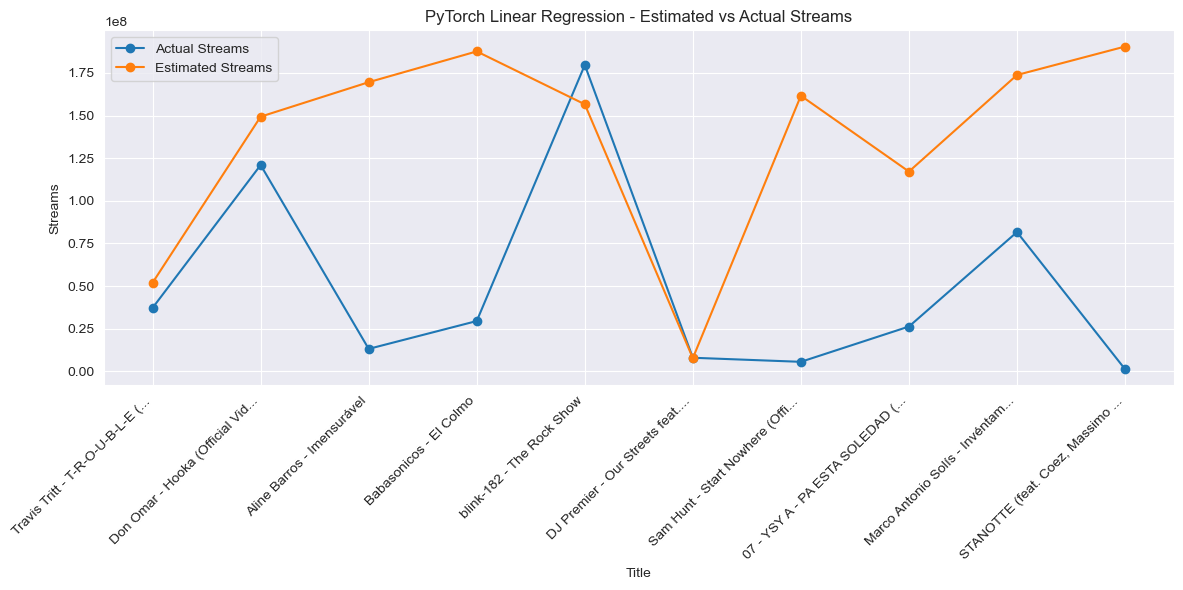

In [247]:
draw_chart(test_predictions, "PyTorch Linear Regression", seed=10)

# 4. End Results

Finally, we can see how everything did and which model turned out to be the best.

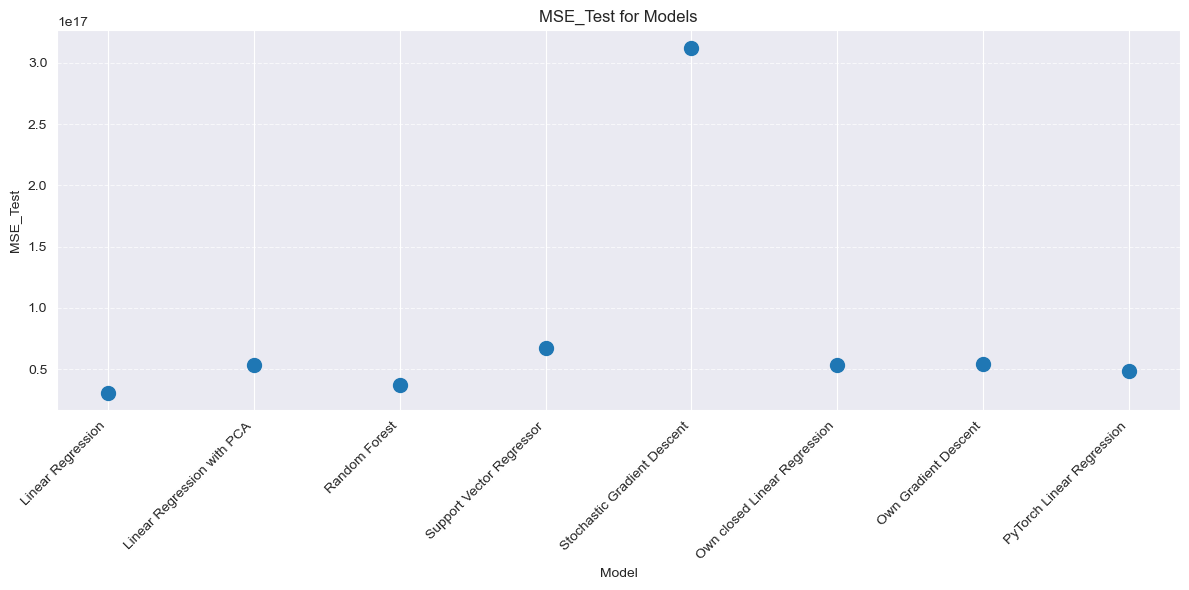

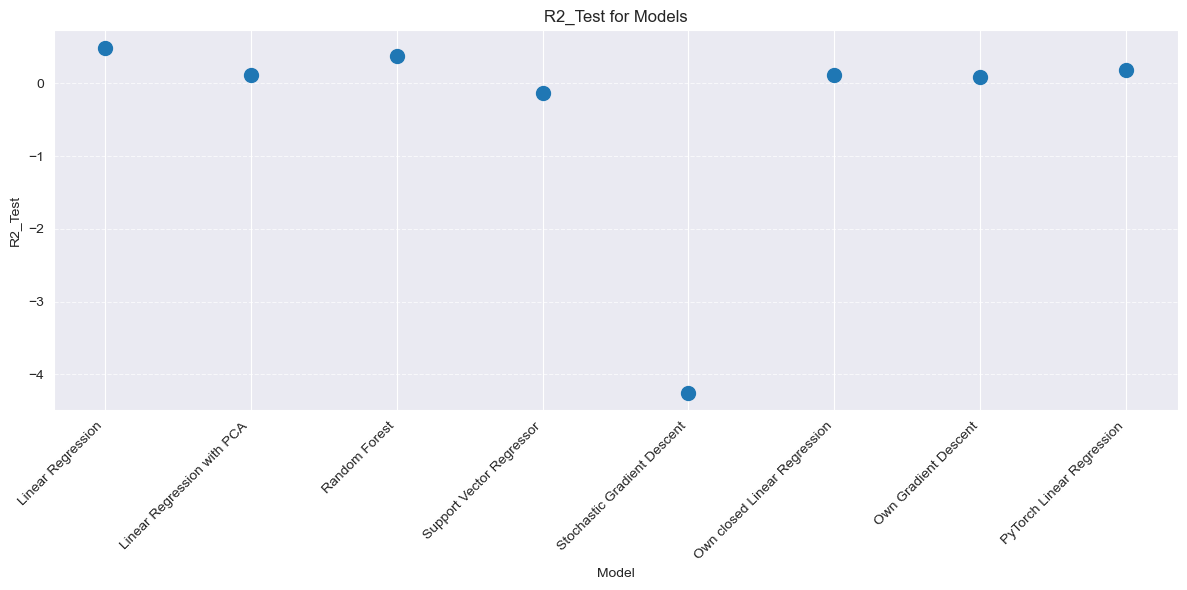

In [248]:
plot_metric_from_csv('estimates/estimated_data.csv', 'MSE_Test')
plot_metric_from_csv('estimates/estimated_data.csv', 'R2_Test')

In [249]:
results = pd.read_csv('estimates/estimated_data.csv')
results.head(10)

,Model,MSE_Train,R2_Train,MSE_Test,R2_Test
0,Linear Regression,6.608596e+10,0.999999,3.041972e+16,0.488201
1,Linear Regression with PCA,5.311953e+16,0.109458,5.311180e+16,0.106416
2,Random Forest,5.516713e+15,0.907513,3.717862e+16,0.374485
3,Support Vector Regressor,6.695343e+16,-0.122466,6.730078e+16,-0.132308
4,Stochastic Gradient Descent,5.437334e+17,-8.115624,3.124991e+17,-4.257671
5,Own closed Linear Regression,5.311953e+16,0.109458,5.311180e+16,0.106416
6,Own Gradient Descent,5.245740e+16,0.120558,5.414419e+16,0.089046
7,PyTorch Linear Regression,4.343452e+16,0.271826,4.852591e+16,0.183571


## Final Summary

Some basic comparison between different models has been done - to be honest, these are simplest approaches, so to really make a model that can somewhat accurately predict how popular will be your song - we would need much more accurate approach and a lot of computational power.

In the end, after testing this on variety of different seeds, there is not really a clear winner. The best models seem to be:
1. Standard Linear Regression - simple to understand and fine-tune and surprisingly gives very good results.
2. Linear Regression with PCA - works much faster than regular, but gives a bit less accurate results.
3. Random Forest - very dependent on the training set - results vary depending on which split seed is set.
4. SVR - terrible in this case - too many important outliers that cannot be omitted.
5. Stochastic Gradient Descent - surprisingly consistently worse than own implementation, plus for extensive fine-tuning possibilities.
6. Own closed Linear Regression - extremely fast (no iteration and PCA), similar results to standard from sklearn.
7. Own Gradient Descent - fast and reliable with adjustable batch size - one of the pros is that time it takes to be trained can be controlled (through iteration limit).
8. PyTorch Linear Regression - fastest (thanks to GPU) and pretty reliable with results - industry standard.
